# Setup

In [22]:
import pandapower.networks as pnet
import pandas as pd
import numpy as np
import scipy as sp
import cvxpy as cp
import seaborn as sns
import mlflow

from scipy import sparse
import matplotlib.pyplot as plt

/Users/jbrouill/PycharmProjects/eiv-grid-id/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [23]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
import sys
sys.path.insert(1, '..')

from src.models.matrix_operations import make_real_vector, vectorize_matrix
from src.simulation.noise import add_polar_noise_to_measurement
from src.models.regression import ComplexRegression, ComplexLasso
from src.models.error_in_variable import TotalLeastSquares, SparseTotalLeastSquare
from src.simulation.load_profile import generate_gaussian_load, BusData
from src.simulation.network import add_load_power_control, make_y_bus, LineData
from src.simulation.simulation import run_simulation, get_current_and_voltage
from src.simulation.net_templates import NetData
from src.identification.error_metrics import error_metrics, fro_error
from src.models.noise_transformation import average_true_noise_covariance,exact_noise_covariance

# Network simulation

In [25]:
mlflow.set_experiment('Big network with polar noise')

In [26]:
bus_data = \
   [BusData(1, 1, 0.160, 0.080, 0.000, 0.000, 1, 1, 0, 4.16, 1, 1.2, 0.8),
    BusData(2, 1, 0.020, 0.010, 0.000, 0.000, 1, 1, 0, 4.16, 1, 1.2, 0.8),
    BusData(3, 1, 0.120, 0.060, 0.000, 0.000, 1, 1, 0, 4.16, 1, 1.2, 0.8),
    BusData(4, 1, 0.100, 0.050, 0.000, 0.000, 1, 1, 0, 4.16, 1, 1.2, 0.8),
    BusData(5, 1, 0.040, 0.020, 0.000, 0.000, 1, 1, 0, 4.16, 1, 1.2, 0.8),
    BusData(6, 1, 0.040, 0.020, 0.000, 0.000, 1, 1, 0, 4.16, 1, 1.2, 0.8),
    BusData(7, 1, 0.000, 0.000, 0.000, 0.000, 1, 1, 0, 4.16, 1, 1.2, 0.8),
    BusData(8, 1, 0.020, 0.010, 0.000, 0.000, 1, 1, 0, 4.16, 1, 1.2, 0.8),
    BusData(9, 1, 0.020, 0.010, 0.000, 0.000, 1, 1, 0, 4.16, 1, 1.2, 0.8),
    BusData(10, 1, 0.040, 0.020, 0.000, 0.000, 1, 1, 0, 4.16, 1, 1.2, 0.8),
    BusData(11, 1, 0.020, 0.010, 0.000, 0.000, 1, 1, 0, 4.16, 1, 1.2, 0.8),
    BusData(12, 1, 0.040, 0.020, 0.000, 0.000, 1, 1, 0, 4.16, 1, 1.2, 0.8),
    BusData(13, 1, 0.040, 0.020, 0.000, 0.000, 1, 1, 0, 4.16, 1, 1.2, 0.8),
    BusData(14, 1, 0.075, 0.035, 0.000, 0.000, 1, 1, 0, 4.16, 1, 1.2, 0.8),
    BusData(15, 1, 0.140, 0.100, 0.000, 0.000, 1, 1, 0, 4.16, 1, 1.2, 0.8),
    BusData(16, 1, 0.075, 0.035, 0.000, 0.000, 1, 1, 0, 4.16, 1, 1.2, 0.8),
    BusData(17, 1, 0.120, 0.060, 0.000, 0.000, 1, 1, 0, 4.16, 1, 1.2, 0.8),
    BusData(18, 1, 0.120, 0.060, 0.000, 0.000, 1, 1, 0, 4.16, 1, 1.2, 0.8),
    BusData(19, 1, 0.245, 0.180, 0.000, 0.000, 1, 1, 0, 4.16, 1, 1.2, 0.8),
    BusData(20, 1, 0.040, 0.020, 0.000, 0.000, 1, 1, 0, 4.16, 1, 1.2, 0.8),
    BusData(21, 1, 0.000, 0.000, 0.000, 0.000, 1, 1, 0, 4.16, 1, 1.2, 0.8),
    BusData(22, 1, 0.040, 0.020, 0.000, 0.000, 1, 1, 0, 4.16, 1, 1.2, 0.8),
    BusData(23, 1, 0.040, 0.020, 0.000, 0.000, 1, 1, 0, 4.16, 1, 1.2, 0.8),
    BusData(24, 1, 0.060, 0.030, 0.000, 0.000, 1, 1, 0, 4.16, 1, 1.2, 0.8),
    BusData(25, 1, 0.040, 0.020, 0.000, 0.000, 1, 1, 0, 4.16, 1, 1.2, 0.8),
    BusData(26, 1, 0.020, 0.010, 0.000, 0.000, 1, 1, 0, 4.16, 1, 1.2, 0.8),
    BusData(27, 1, 0.020, 0.010, 0.000, 0.000, 1, 1, 0, 4.16, 1, 1.2, 0.8),
    BusData(28, 1, 0.080, 0.040, 0.000, 0.000, 1, 1, 0, 4.16, 1, 1.2, 0.8),
    BusData(29, 1, 0.040, 0.020, 0.000, 0.000, 1, 1, 0, 4.16, 1, 1.2, 0.8),
    BusData(30, 1, 0.040, 0.020, 0.000, 0.000, 1, 1, 0, 4.16, 1, 1.2, 0.8),
    BusData(31, 1, 0.040, 0.020, 0.000, 0.000, 1, 1, 0, 4.16, 1, 1.2, 0.8),
    BusData(32, 1, 0.040, 0.020, 0.000, 0.000, 1, 1, 0, 4.16, 1, 1.2, 0.8),
    BusData(33, 1, 0.000, 0.000, 0.000, 0.000, 1, 1, 0, 4.16, 1, 1.2, 0.8),
    BusData(34, 1, 0.040, 0.020, 0.000, 0.000, 1, 1, 0, 4.16, 1, 1.2, 0.8),
    BusData(35, 1, 0.040, 0.020, 0.000, 0.000, 1, 1, 0, 4.16, 1, 1.2, 0.8),
    BusData(36, 1, 0.040, 0.020, 0.000, 0.000, 1, 1, 0, 4.16, 1, 1.2, 0.8),
    BusData(37, 1, 0.100, 0.050, 0.000, 0.000, 1, 1, 0, 4.16, 1, 1.2, 0.8),
    BusData(38, 1, 0.080, 0.040, 0.000, 0.000, 1, 1, 0, 4.16, 1, 1.2, 0.8),
    BusData(39, 1, 0.140, 0.070, 0.000, 0.000, 1, 1, 0, 4.16, 1, 1.2, 0.8),
    BusData(40, 1, 0.080, 0.040, 0.000, 0.000, 1, 1, 0, 4.16, 1, 1.2, 0.8),
    BusData(41, 1, 0.040, 0.020, 0.000, 0.000, 1, 1, 0, 4.16, 1, 1.2, 0.8),
    BusData(42, 1, 0.040, 0.020, 0.000, 0.000, 1, 1, 0, 4.16, 1, 1.2, 0.8),
    BusData(43, 1, 0.080, 0.040, 0.000, 0.000, 1, 1, 0, 4.16, 1, 1.2, 0.8),
    BusData(44, 1, 0.040, 0.020, 0.000, 0.000, 1, 1, 0, 4.16, 1, 1.2, 0.8),
    BusData(45, 1, 0.040, 0.020, 0.000, 0.000, 1, 1, 0, 4.16, 1, 1.2, 0.8),
    BusData(46, 1, 0.040, 0.020, 0.000, 0.000, 1, 1, 0, 4.16, 1, 1.2, 0.8),
    BusData(47, 1, 0.120, 0.060, 0.000, 0.000, 1, 1, 0, 4.16, 1, 1.2, 0.8),
    BusData(48, 1, 0.020, 0.010, 0.000, 0.000, 1, 1, 0, 4.16, 1, 1.2, 0.8),
    BusData(49, 1, 0.060, 0.030, 0.000, 0.000, 1, 1, 0, 4.16, 1, 1.2, 0.8),
    BusData(50, 1, 0.040, 0.020, 0.000, 0.000, 1, 1, 0, 4.16, 1, 1.2, 0.8),
    BusData(51, 1, 0.105, 0.075, 0.000, 0.000, 1, 1, 0, 4.16, 1, 1.2, 0.8),
    BusData(52, 1, 0.210, 0.150, 0.000, 0.000, 1, 1, 0, 4.16, 1, 1.2, 0.8),
    BusData(53, 1, 0.140, 0.095, 0.000, 0.000, 1, 1, 0, 4.16, 1, 1.2, 0.8),
    BusData(54, 1, 0.040, 0.020, 0.000, 0.000, 1, 1, 0, 4.16, 1, 1.2, 0.8),
    BusData(55, 1, 0.020, 0.010, 0.000, 0.000, 1, 1, 0, 4.16, 1, 1.2, 0.8),
    BusData(56, 3, 0.000, 0.000, 0.000, 0.000, 1, 1, 0, 4.16, 1, 1.2, 0.8)]
for b in bus_data:
    b.id = b.id-1

net_data = \
   [LineData(56, 1, 0.0013398623, 0.0027450827, 3.02770271595392E-008, 100, 100, 100, 0, 0, 1, -360, 360, 400),
    LineData(1, 2, 0.0010048967, 0.0020588120, 2.27077703696544E-008, 100, 100, 100, 0, 0, 1, -360, 360, 300),
    LineData(2, 3, 0.0006699312, 0.0013725413, 1.51385135797696E-008, 100, 100, 100, 0, 0, 1, -360, 360, 200),
    LineData(3, 4, 0.0010048967, 0.0020588120, 2.27077703696544E-008, 100, 100, 100, 0, 0, 1, -360, 360, 300),
    LineData(4, 5, 0.0013398623, 0.0027450827, 3.02770271595392E-008, 100, 100, 100, 0, 0, 1, -360, 360, 400),
    LineData(5, 6, 0.0006699312, 0.0013725413, 1.51385135797696E-008, 100, 100, 100, 0, 0, 1, -360, 360, 200),
    LineData(6, 7, 0.0004187070, 0.0008578383, 9.46157098735599E-009, 100, 100, 100, 0, 0, 1, -360, 360, 125),
    LineData(7, 8, 0.0009211553, 0.0018872444, 2.08154561721832E-008, 100, 100, 100, 0, 0, 1, -360, 360, 275),
    LineData(8, 9, 0.0009211553, 0.0018872444, 2.08154561721832E-008, 100, 100, 100, 0, 0, 1, -360, 360, 275),
    LineData(7, 10, 0.0011723795, 0.0024019474, 2.64923987645968E-008, 100, 100, 100, 0, 0, 1, -360, 360, 350),
    LineData(10, 11, 0.0025122418, 0.0051470300, 5.67694259241360E-008, 100, 100, 100, 0, 0, 1, -360, 360, 750),
    LineData(11, 12, 0.0027749546, 0.0013221274, 1.83926822251266E-007, 100, 100, 100, 0, 0, 1, -360, 360, 250),
    LineData(12, 13, 0.0019424682, 0.0009254892, 1.28748775575886E-007, 100, 100, 100, 0, 0, 1, -360, 360, 175),
    LineData(13, 14, 0.0038849364, 0.0018509784, 2.57497551151773E-007, 100, 100, 100, 0, 0, 1, -360, 360, 350),
    LineData(14, 15, 0.0047174228, 0.0022476166, 3.12675597827153E-007, 100, 100, 100, 0, 0, 1, -360, 360, 425),
    LineData(15, 16, 0.0036074409, 0.0017187657, 2.39104868926646E-007, 100, 100, 100, 0, 0, 1, -360, 360, 325),
    LineData(11, 17, 0.0011723795, 0.0024019474, 2.64923987645968E-008, 100, 100, 100, 0, 0, 1, -360, 360, 350),
    LineData(17, 18, 0.0009211553, 0.0018872444, 2.08154561721832E-008, 100, 100, 100, 0, 0, 1, -360, 360, 275),
    LineData(18, 19, 0.0006699312, 0.0013725413, 1.51385135797696E-008, 100, 100, 100, 0, 0, 1, -360, 360, 200),
    LineData(19, 20, 0.0013398623, 0.0027450827, 3.02770271595392E-008, 100, 100, 100, 0, 0, 1, -360, 360, 400),
    LineData(20, 21, 0.0003349656, 0.0006862707, 7.56925678988480E-009, 100, 100, 100, 0, 0, 1, -360, 360, 100),
    LineData(21, 22, 0.0007536726, 0.0015441090, 1.70000000000000E-008, 100, 100, 100, 0, 0, 1, -360, 360, 225),
    LineData(21, 23, 0.0015910865, 0.0032597857, 3.60000000000000E-008, 100, 100, 100, 0, 0, 1, -360, 360, 475),
    LineData(23, 24, 0.0015910865, 0.0032597857, 3.60000000000000E-008, 100, 100, 100, 0, 0, 1, -360, 360, 475),
    LineData(24, 25, 0.0008374139, 0.0017156767, 1.89231419747120E-008, 100, 100, 100, 0, 0, 1, -360, 360, 250),
    LineData(25, 26, 0.0008374139, 0.0017156767, 1.89231419747120E-008, 100, 100, 100, 0, 0, 1, -360, 360, 250),
    LineData(19, 27, 0.0023447590, 0.0048038947, 5.30000000000000E-008, 100, 100, 100, 0, 0, 1, -360, 360, 700),
    LineData(27, 28, 0.0015073451, 0.0030882180, 3.40616555544816E-008, 100, 100, 100, 0, 0, 1, -360, 360, 450),
    LineData(28, 29, 0.0009211553, 0.0018872444, 2.08154561721832E-008, 100, 100, 100, 0, 0, 1, -360, 360, 275),
    LineData(29, 30, 0.0007536726, 0.0015441090, 1.70000000000000E-008, 100, 100, 100, 0, 0, 1, -360, 360, 225),
    LineData(30, 31, 0.0007536726, 0.0015441090, 1.70000000000000E-008, 100, 100, 100, 0, 0, 1, -360, 360, 225),
    LineData(31, 32, 0.0010048967, 0.0020588120, 2.27077703696544E-008, 100, 100, 100, 0, 0, 1, -360, 360, 300),
    LineData(17, 33, 0.0008374139, 0.0017156767, 1.89231419747120E-008, 100, 100, 100, 0, 0, 1, -360, 360, 250),
    LineData(33, 34, 0.0009211553, 0.0018872444, 2.08154561721832E-008, 100, 100, 100, 0, 0, 1, -360, 360, 275),
    LineData(34, 35, 0.0018423107, 0.0037744887, 4.16309123443664E-008, 100, 100, 100, 0, 0, 1, -360, 360, 550),
    LineData(35, 36, 0.0010048967, 0.0020588120, 2.27077703696544E-008, 100, 100, 100, 0, 0, 1, -360, 360, 300),
    LineData(33, 37, 0.0008374139, 0.0017156767, 1.89231419747120E-008, 100, 100, 100, 0, 0, 1, -360, 360, 250),
    LineData(37, 38, 0.0009211553, 0.0018872444, 2.08154561721832E-008, 100, 100, 100, 0, 0, 1, -360, 360, 275),
    LineData(38, 39, 0.0010886381, 0.0022303797, 2.46000845671256E-008, 100, 100, 100, 0, 0, 1, -360, 360, 325),
    LineData(4, 40, 0.0027634660, 0.0056617331, 6.24463685165496E-008, 100, 100, 100, 0, 0, 1, -360, 360, 825),
    LineData(40, 41, 0.0010048967, 0.0020588120, 2.27077703696544E-008, 100, 100, 100, 0, 0, 1, -360, 360, 300),
    LineData(41, 42, 0.0008374139, 0.0017156767, 1.89231419747120E-008, 100, 100, 100, 0, 0, 1, -360, 360, 250),
    LineData(42, 43, 0.0009211553, 0.0018872444, 2.08154561721832E-008, 100, 100, 100, 0, 0, 1, -360, 360, 275),
    LineData(43, 44, 0.0006699312, 0.0013725413, 1.51385135797696E-008, 100, 100, 100, 0, 0, 1, -360, 360, 200),
    LineData(44, 45, 0.0010048967, 0.0020588120, 2.27077703696544E-008, 100, 100, 100, 0, 0, 1, -360, 360, 300),
    LineData(45, 46, 0.0011723795, 0.0024019474, 2.64923987645968E-008, 100, 100, 100, 0, 0, 1, -360, 360, 350),
    LineData(40, 47, 0.0012561209, 0.0025735150, 2.83847129620680E-008, 100, 100, 100, 0, 0, 1, -360, 360, 375),
    LineData(47, 48, 0.0008374139, 0.0017156767, 1.89231419747120E-008, 100, 100, 100, 0, 0, 1, -360, 360, 250),
    LineData(48, 49, 0.0008374139, 0.0017156767, 1.89231419747120E-008, 100, 100, 100, 0, 0, 1, -360, 360, 250),
    LineData(49, 50, 0.0006699312, 0.0013725413, 1.51385135797696E-008, 100, 100, 100, 0, 0, 1, -360, 360, 200),
    LineData(50, 51, 0.0008374139, 0.0017156767, 1.89231419747120E-008, 100, 100, 100, 0, 0, 1, -360, 360, 250),
    LineData(51, 52, 0.0005024484, 0.0010294060, 1.13538851848272E-008, 100, 100, 100, 0, 0, 1, -360, 360, 150),
    LineData(51, 53, 0.0008374139, 0.0017156767, 1.89231419747120E-008, 100, 100, 100, 0, 0, 1, -360, 360, 250),
    LineData(53, 54, 0.0008374139, 0.0017156767, 1.89231419747120E-008, 100, 100, 100, 0, 0, 1, -360, 360, 250),
    LineData(54, 55, 0.0008374139, 0.0017156767, 1.89231419747120E-008, 100, 100, 100, 0, 0, 1, -360, 360, 250)]
for l in net_data:
    l.length = l.length*0.3048/1000
    l.start_bus = l.start_bus - 1
    l.end_bus = l.end_bus - 1

In [27]:
net = NetData(bus_data, net_data)

nodes = len(bus_data)
steps = 400
load_cv = 0.5
current_magnitude_sd = 1e-6
voltage_magnitude_sd = 1e-6
phase_sd = 1e-6/np.pi

In [28]:
np.random.seed(11)
load_p, load_q = generate_gaussian_load(net.load.p_mw, net.load.q_mvar, load_cv, steps)
controlled_net = add_load_power_control(net, load_p, load_q)
sim_result = run_simulation(controlled_net, verbose=False)
y_bus = make_y_bus(controlled_net)
voltage, current = get_current_and_voltage(sim_result, y_bus)
controlled_net.bus

No time steps to calculate are specified. I'll check the datasource of the first controller for avaiable time steps


,name,vn_kv,type,zone,in_service
0,0,4.16,b,None,True
1,1,4.16,b,None,True
2,2,4.16,b,None,True
3,3,4.16,b,None,True
4,4,4.16,b,None,True
5,5,4.16,b,None,True
6,6,4.16,b,None,True
7,7,4.16,b,None,True
8,8,4.16,b,None,True
9,9,4.16,b,None,True


In [29]:
current = np.array(voltage @ y_bus)
current_magnitude_sd = current_magnitude_sd*np.mean(current)
noisy_voltage = add_polar_noise_to_measurement(voltage, voltage_magnitude_sd, phase_sd)
noisy_current = add_polar_noise_to_measurement(current, current_magnitude_sd, phase_sd)
voltage_error, current_error = noisy_voltage - voltage, noisy_current - current

/Users/jbrouill/PycharmProjects/eiv-grid-id/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
../src/simulation/noise.py:31: ComplexWarning: Casting complex values to real discards the imaginary part
  magnitude_noise = np.random.normal(0, magnitude_sd, magnitude.shape)


In [30]:
np.linalg.svd(voltage, compute_uv=False)

array([1.49256498e+02, 1.94444158e-02, 8.68750956e-03, 3.44619855e-03,
       1.95278216e-03, 1.82030321e-03, 1.44454624e-03, 7.12418787e-04,
       5.48323511e-04, 4.20540974e-04, 3.84864621e-04, 3.06093344e-04,
       2.46803242e-04, 2.35992089e-04, 1.64978209e-04, 1.60363654e-04,
       1.45679770e-04, 1.27545394e-04, 1.22014379e-04, 1.06347121e-04,
       9.51407227e-05, 8.75582341e-05, 6.88603123e-05, 6.49503661e-05,
       6.09056403e-05, 5.61986128e-05, 5.23023717e-05, 5.03225844e-05,
       4.74015351e-05, 4.34651236e-05, 4.11910599e-05, 3.97655813e-05,
       3.69147831e-05, 3.51522025e-05, 3.10209270e-05, 2.92471868e-05,
       2.62544401e-05, 2.42523061e-05, 2.30451327e-05, 2.25614690e-05,
       2.07285964e-05, 1.82513767e-05, 1.64709637e-05, 1.54546100e-05,
       1.50557269e-05, 1.45387522e-05, 1.30787547e-05, 1.20304573e-05,
       1.16607562e-05, 1.10941230e-05, 9.89773797e-06, 9.21152247e-06,
       8.87560232e-06, 1.30426990e-14, 2.99307328e-15, 2.79419283e-15])

In [31]:
np.mean(np.abs(current), 0)

array([1.82910948e-01, 2.35614632e-02, 1.40955627e-01, 1.16997996e-01,
       4.77363033e-02, 4.87942865e-02, 4.86600145e-12, 2.42800190e-02,
       2.28487369e-02, 4.66237428e-02, 2.38199967e-02, 4.79148543e-02,
       4.75501864e-02, 8.64407529e-02, 1.79931690e-01, 8.59976931e-02,
       1.48145537e-01, 1.35248328e-01, 3.19699014e-01, 4.72801889e-02,
       6.27038436e-12, 4.72765609e-02, 4.76925546e-02, 6.93994275e-02,
       4.78467846e-02, 2.42353916e-02, 2.39832649e-02, 9.63031987e-02,
       4.87499341e-02, 4.62304412e-02, 4.65096544e-02, 4.67414196e-02,
       4.14719210e-12, 4.65438130e-02, 4.67763296e-02, 4.84251223e-02,
       1.19080322e-01, 9.45695323e-02, 1.64913029e-01, 9.58045161e-02,
       4.77680746e-02, 4.66648751e-02, 9.52384086e-02, 4.74638654e-02,
       4.65836521e-02, 4.74824936e-02, 1.46996710e-01, 2.36420481e-02,
       6.81471115e-02, 4.68495626e-02, 1.38178956e-01, 2.76184397e-01,
       1.79113264e-01, 4.77416196e-02, 2.34192931e-02, 4.00687797e+00])

In [32]:
mlflow_params = {
    'nodes': noisy_voltage.shape[1],
    'steps': steps, 
    'load_cv': load_cv, 
    'current_magnitude_sd': current_magnitude_sd, 
    'voltage_magnitude_sd': voltage_magnitude_sd,
    'phase_sd': phase_sd
}

# TLS Identification

In [33]:
with mlflow.start_run(run_name='TLS'):
    tls = TotalLeastSquares()
    tls.fit(noisy_voltage, noisy_current)
    y_tls = tls.fitted_admittance_matrix
    tls_metrics = error_metrics(y_bus, y_tls)
    mlflow.log_params(mlflow_params)
    mlflow.log_metrics(tls_metrics.__dict__)
tls_metrics

[[-1.75182018e-03+2.58239417e-04j -3.10466793e-06+1.51462646e-04j
  -1.63955271e-03+4.77007250e-04j ...  7.72588805e-08-2.39169944e-07j
  -9.13182889e-08+5.14060243e-08j -2.99153071e-08+6.78275864e-08j]
 [-1.74216093e-03+2.47705019e-04j -2.19647817e-05+1.36499213e-04j
  -1.65391144e-03+4.88198105e-04j ...  7.72687537e-08-2.39199047e-07j
  -9.13488541e-08+5.13952368e-08j -2.99452088e-08+6.77970724e-08j]
 [-1.73649189e-03+2.54747427e-04j -1.30519333e-05+1.33796059e-04j
  -1.66379539e-03+4.87394216e-04j ...  7.72730486e-08-2.39274126e-07j
  -9.13620979e-08+5.14186932e-08j -2.99646296e-08+6.77630922e-08j]
 ...
 [-2.06190632e-03+4.20994218e-04j -8.46680848e-05+9.87892777e-05j
  -1.65136833e-03+3.42620275e-04j ...  7.65011552e-08-2.40404053e-07j
  -9.09764021e-08+5.26816126e-08j -3.02104490e-08+6.67591809e-08j]
 [-2.07860742e-03+4.33872139e-04j -1.14166707e-04+7.93783202e-05j
  -1.65958796e-03+3.43329314e-04j ...  7.63981446e-08-2.40468626e-07j
  -9.10014035e-08+5.27504245e-08j -3.02612919e-

ErrorMetrics(fro_error=139599.9051392997, max_error=37504.17526077836, rrms_error=0.8702352220693096, map_error=0.26597941069015846)

# L1 Regularized TLS

normalizing currents

In [43]:
with mlflow.start_run(run_name='S-TLS with covariance'):
    max_iterations = 150
    abs_tol = 0.1
    rel_tol = 10e-9
    solver = cp.GUROBI
    use_cov_matrix = True
    pen_degree=1.0
    tls_weights_adaptive = np.divide(1.0, np.power(np.abs(make_real_vector(vectorize_matrix(y_tls))), 1.0))
    
    
    sigma_voltage = average_true_noise_covariance(noisy_voltage, voltage_magnitude_sd, phase_sd)
    sigma_current = average_true_noise_covariance(noisy_current, current_magnitude_sd, phase_sd)
    
    #sigma_voltage = exact_noise_covariance(voltage, voltage_magnitude_sd, phase_sd)
    #sigma_current = exact_noise_covariance(current, current_magnitude_sd, phase_sd)

    if max_iterations > 0:
        inv_sigma_current = sparse.linalg.inv(sigma_current)
        inv_sigma_voltage = sparse.linalg.inv(sigma_voltage)
    else:
        inv_sigma_current = sigma_current
        inv_sigma_voltage = sigma_voltage
    
    sparse_tls_cov = SparseTotalLeastSquare(lambda_value=0.1, abs_tol=abs_tol, rel_tol=rel_tol, solver=solver, max_iterations=max_iterations)
    sparse_tls_cov.l1_multiplier_step_size = 0*0.0000000001
    sparse_tls_cov.cons_multiplier_step_size = 0.001
    #sparse_tls_cov.set_prior(make_real_vector(vectorize_matrix(np.zeros(y_tls.shape))), SparseTotalLeastSquare.LAPLACE,
    #                         np.diag(tls_weights_adaptive))

    sparse_tls_cov.l1_target = 2*np.count_nonzero(y_bus)
    sparse_tls_cov.l1_target = 1.0*(np.sum(np.power(np.abs(np.real(y_bus)),pen_degree))
                                    + np.sum(np.power(np.abs(np.imag(y_bus)),pen_degree)))
    sparse_tls_cov.l1_target = 1.0*2*np.sum(np.abs(make_real_vector(np.diag(y_tls))))

    sparse_tls_cov.fit(noisy_voltage, noisy_current, inv_sigma_voltage, inv_sigma_current, y_init=y_tls)
    
    y_sparse_tls_cov = sparse_tls_cov.fitted_admittance_matrix
    sparse_tls_cov_metrics = error_metrics(y_bus, y_sparse_tls_cov)
    
    sparse_tls_cov_errors = pd.Series([fro_error(y_bus, i.fitted_parameters) for i in sparse_tls_cov.iterations])
    sparse_tls_cov_targets = pd.Series([i.target_function for i in sparse_tls_cov.iterations])

    mlflow.log_param('max_iterations', max_iterations)
    mlflow.log_param('abs_tol', abs_tol)
    mlflow.log_param('rel_tol', rel_tol)
    mlflow.log_param('solver', solver)
    mlflow.log_param('use_cov_matrix', use_cov_matrix)
    mlflow.log_params(mlflow_params)
    mlflow.log_metrics(sparse_tls_cov_metrics.__dict__)

    for i in range(len(sparse_tls_cov_errors)):
        mlflow.log_metric('fro_error_evo', value=sparse_tls_cov_errors[i], step=i)
        mlflow.log_metric('opt_cost_evo', value=sparse_tls_cov_targets[i], step=i)

/Users/jbrouill/PycharmProjects/eiv-grid-id/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
  0%|          | 0/150 [00:00<?, ?it/s]/Users/jbrouill/PycharmProjects/eiv-grid-id/venv/lib/python3.8/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:144: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',
100%|██████████| 150/150 [4:28:36<00:00, 107.45s/it]  


<AxesSubplot:>

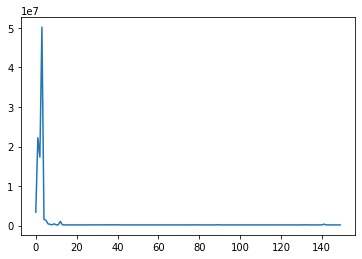

In [44]:
#sparse_tls_cov_errors.plot()
#sparse_tls_cov_targets.copy().multiply(0.00004).plot()


/Users/jbrouill/PycharmProjects/eiv-grid-id/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/Users/jbrouill/PycharmProjects/eiv-grid-id/venv/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


<AxesSubplot:>

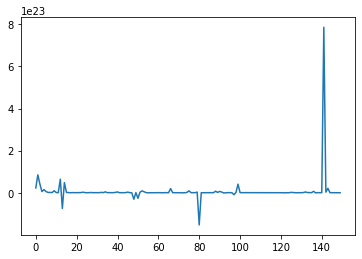

In [45]:
#sparse_tls_cov_targets.plot()

/Users/jbrouill/PycharmProjects/eiv-grid-id/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


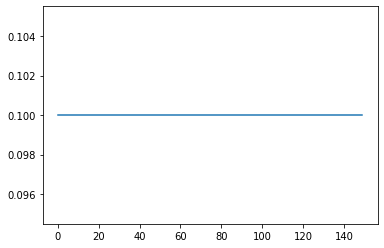

In [46]:
#plt.plot(sparse_tls_cov.tmp)

# Result analysis

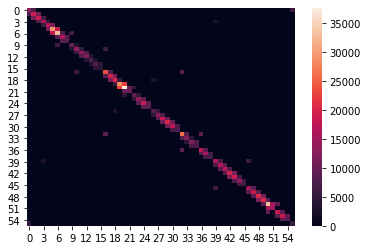

In [47]:
#sns.heatmap(np.abs(y_bus));

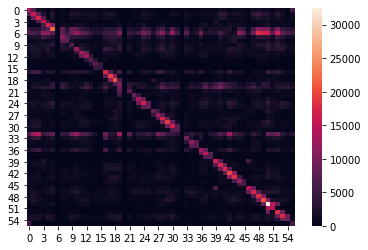

In [48]:
#sns.heatmap(np.abs(y_tls));

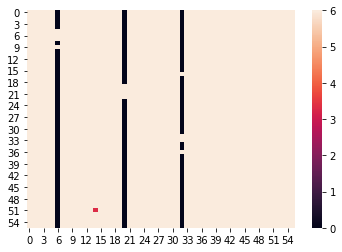

In [49]:
#sns.heatmap(np.abs(y_bus - y_tls),vmin=0,vmax=6);

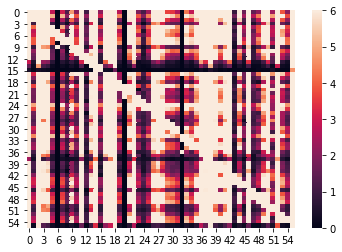

In [50]:
#sns.heatmap(np.abs(y_bus - y_sparse_tls_cov),vmin=0,vmax=6);

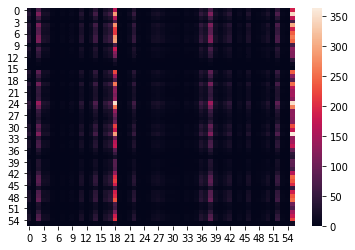

In [51]:
#sns.heatmap(np.abs(y_sparse_tls_cov));

In [ ]:
print(y_sparse_tls_cov)